# Imports and Data Download

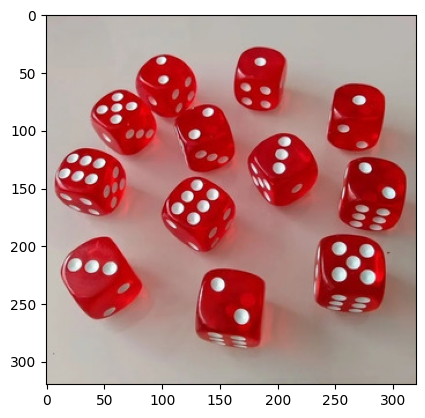

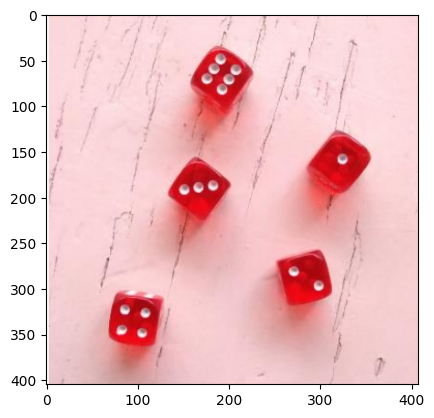

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


names_list = ["dados2.jpg", "dados3.png"]

img_list = []
for i, name in enumerate(names_list):
    img_list.append(cv2.imread(name))
    img_list[i] = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB)
#   cv2.imshow(f'{name}',img_list[-1])

def show_imgs(img_list):
    for img in img_list:
        # cmap=plt.get_cmap('gray')
        plt.imshow(img,cmap='gray')
        plt.show()
        
show_imgs(img_list)

# Image preprocessing

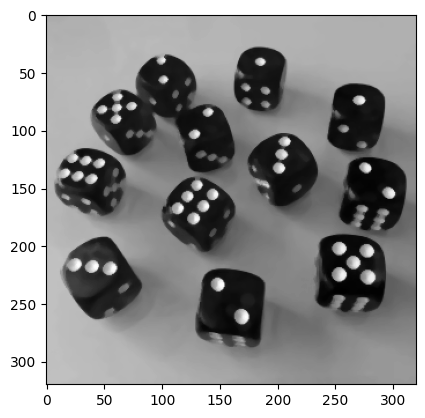

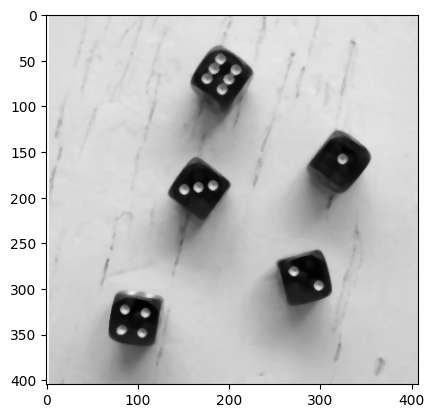

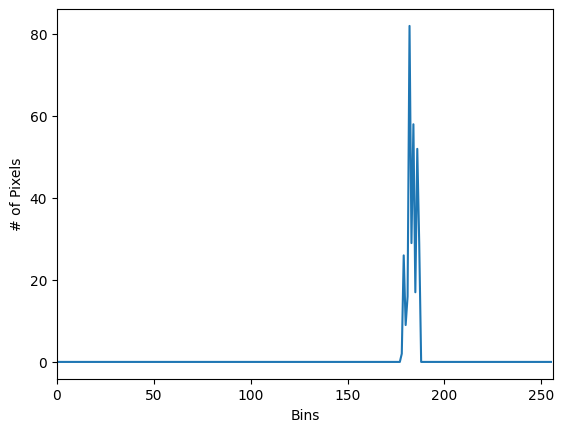

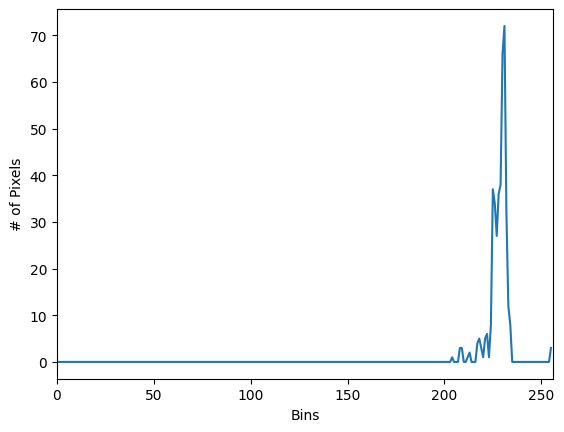

In [18]:
# Removing colors
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in img_list]

# Applying median blur for better feature extraction
median_imgs = [cv2.medianBlur(img, 5) for img in gray_imgs]

show_imgs(median_imgs)

# hists = [np.histogram(img, bins=256, range=(0, 1)) for img in median_imgs]
def histograms(img_list):
    for img in img_list:
        hist = cv2.calcHist(img, [0], None, [256], [0, 256])
        
        plt.figure()
        plt.xlabel("Bins")
        plt.ylabel("# of Pixels")
        plt.plot(hist)
        plt.xlim([0, 256])
        
histograms(median_imgs)

# Algorithm

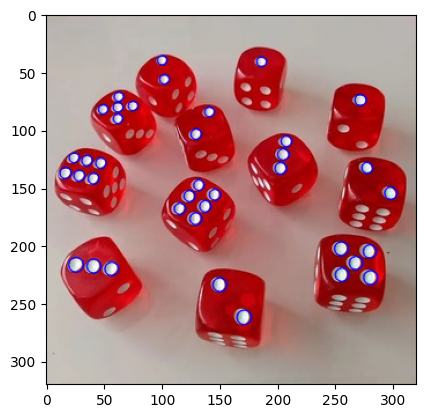

'Number of dice rolled: '

12

'Sum of the roll: '

38

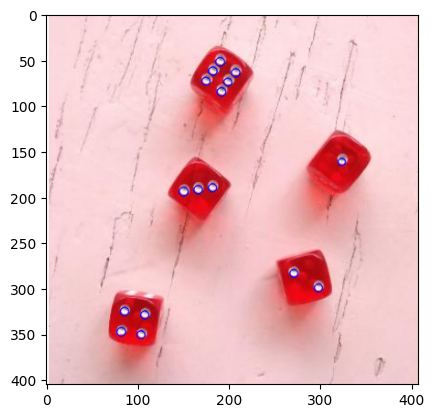

'Number of dice rolled: '

5

'Sum of the roll: '

16

In [19]:
from sklearn.cluster import DBSCAN as dbs

for i, img in enumerate(median_imgs):

    (thresh, img) = cv2.threshold(img, 190, 255, cv2.THRESH_BINARY)#+cv2.THRESH_OTSU)#cv2.THRESH_BINARY)
    
    kernel = np.ones((3,3),np.uint8)
    
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    img = cv2.dilate(img,kernel,iterations = 1)
    
    # img = cv2.erode(img,kernel,iterations = 1)
    
    img = cv2.bitwise_not(img)
    
    # img = cv2.Sobel(src=img, ddepth=-1, dx=1, dy=1, ksize=3) # Sobel Edge Detection on the Y axis
    # Detecting dots

    params = cv2.SimpleBlobDetector_Params()
    
    params.minDistBetweenBlobs = 0

    # params.minThreshold = 90
    # params.maxThreshold = 255

    # params.filterByCircularity = True
    # params.minCircularity = 0.3

    params.filterByConvexity = True
    params.minConvexity = 0.1

    # params.filterByInertia = True
    # params.minInertiaRatio = 0.5

    params.filterByArea = True
    params.minArea = 1
    # params.maxArea = 100

    detector = cv2.SimpleBlobDetector_create(params)
    dots = detector.detect(img)
    
    # img = cv2.drawKeypoints(img, dots, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    img = cv2.drawKeypoints(img_list[i], dots, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.imshow(img)
    plt.show()


    # Clusterization
    coords = []
    for dot in dots:
        dot = dot.pt
        coords.append(dot)
    
    clusters = dbs(eps=35.5, min_samples=1).fit(coords)

    labels = np.unique(clusters.labels_)

    roll_sum = len(clusters.labels_)
    dice_number = len(labels)


    display("Number of dice rolled: ",dice_number)
    display("Sum of the roll: ", roll_sum)